# Import and set up plot_clump() function

In [2]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as con

z_arr = np.arange(4.000, 12.200, 0.200)

In [3]:
def plot_clump(base):

    # Set up arrays
    clump_arr       = np.zeros(len(z_arr))              # Clumping factor array using original definition
    clump_HII_arr   = np.zeros(len(z_arr))              # Clumping factor array using C_HII definition
    clump_R_arr     = np.zeros(len(z_arr))              # Clumping factor array using C_R definition

    for i in range(len(clump_arr)):
        # Format file name to have 3 decimal places
        file  = base+'los2048_n5000_z{0:.3f}.dat'.format(z_arr[i])

        # Open the binary file
        readdata = open(file,"rb")


        # Header data
        ztime  = np.fromfile(readdata,dtype=np.double,count=1) # redshift
        omegaM = np.fromfile(readdata,dtype=np.double,count=1) # Omega_m (matter density)
        omegaL = np.fromfile(readdata,dtype=np.double,count=1) # Omega_L (Lambda density)
        omegab = np.fromfile(readdata,dtype=np.double,count=1) # Omega_b (baryon density)
        h100   = np.fromfile(readdata,dtype=np.double,count=1) # Hubble constant, H0 / 100 km/s/Mpc
        box100 = np.fromfile(readdata,dtype=np.double,count=1) # Box size in comoving kpc/h
        Xh     = np.fromfile(readdata,dtype=np.double,count=1) # Hydrogen fraction by mass
        nbins  = np.fromfile(readdata,dtype=np.int32,count=1)  # Number of pixels in each line of sight
        numlos = np.fromfile(readdata,dtype=np.int32,count=1)  # Number of lines of sight

        # Line of sight locations in box 
        iaxis  = np.fromfile(readdata,dtype=np.int32,count=numlos[0])  # projection axis, x=1, y=2, z=3
        xaxis  = np.fromfile(readdata,dtype=np.double,count=numlos[0]) # x-coordinate in comoving kpc/h
        yaxis  = np.fromfile(readdata,dtype=np.double,count=numlos[0]) # y-coordinate in comoving kpc/h
        zaxis  = np.fromfile(readdata,dtype=np.double,count=numlos[0]) # z-coordinate in comoving kpc/h

        # Line of sight scale
        posaxis = np.fromfile(readdata,dtype=np.double,count=nbins[0]) # comoving kpc/h
        velaxis = np.fromfile(readdata,dtype=np.double,count=nbins[0]) # km/s

        # Gas density, rho/<rho>
        density = np.fromfile(readdata,dtype=np.double,count=nbins[0]*numlos[0])

        # H1 fraction, fH1 = nH1/nH
        H1frac  = np.fromfile(readdata,dtype=np.double,count=nbins[0]*numlos[0])

        # Temperature, K
        temp    = np.fromfile(readdata,dtype=np.double,count=nbins[0]*numlos[0])

        # Peculiar velocity, km/s
        vpec    = np.fromfile(readdata,dtype=np.double,count=nbins[0]*numlos[0])

        # Close the binary file
        readdata.close()

        # Calculate clumping factor for gas with Delta<Dlim
        Dlim = 100.0
        ind = np.where(density <= Dlim)

        # Can calculate Y_He from X_H (variable = Xh)
        Yhe = 1 - Xh
        alpha_HII = 4.06E-19 * (temp / 1E4)**-0.72

        # Store clumping factor in array
        clump_arr[i] = np.mean(density[ind]**2.0)/np.mean(density[ind])**2.0

        # The quantity over which to calculate the mean value for C_HII
        clump_HII_factor = (1 - H1frac[ind]) * density[ind]
        clump_HII_arr[i] = np.mean(clump_HII_factor**2.0)/np.mean(clump_HII_factor)**2.0

        # The quantity over which to calculate the mean value for C_R
        clump_R_arr[i] = np.mean(clump_HII_factor**2 * alpha_HII[ind]) / (np.mean(clump_HII_factor)**2 * np.mean(alpha_HII[ind]))
    return clump_arr, clump_HII_arr, clump_R_arr


# Cells to get clump factors for different dark matter models

In [93]:
base = './planck1_20_1024_cold/'
clump_arr, clump_HII_arr, clump_R_arr = plot_clump(base)

KeyboardInterrupt: 

In [ ]:
base = './planck1_20_1024_hot/'
clump_arr, clump_HII_arr, clump_R_arr = plot_clump(base)

# Plot graph

Maximum clumping factor: 6.84
Minimum clumping factor: 2.60


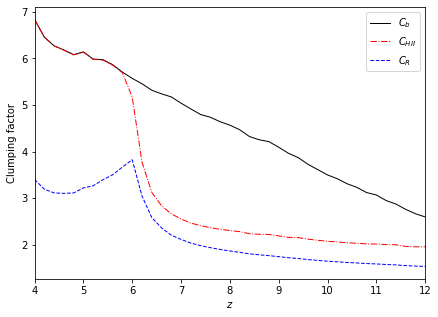

In [71]:
print('Maximum clumping factor: {0:.2f}'.format(np.amax(clump_arr)))
print('Minimum clumping factor: {0:.2f}'.format(np.amin(clump_arr)))

plt.figure(figsize=(7, 5))
plt.plot(z_arr, clump_arr, 'black', linewidth=1, label="$C_b$")
plt.plot(z_arr, clump_HII_arr, '-.', color='red', linewidth=1, label="$C_{HII}$")
plt.plot(z_arr, clump_R_arr, '--', color='blue', linewidth=1, label="$C_R$")

plt.xlabel('$z$')
plt.ylabel('Clumping factor')
plt.xlim(np.amin(z_arr), np.amax(z_arr))
#plt.ylim(np.floor(np.amin(clump_arr)), np.ceil(np.amax(clump_arr)))
plt.legend()
#plt.title('Relationship between clumping factor and redshift, Dlim = {0:.1f}, C = $\\frac{\\langle \\rho^2 \\rangle}{\\langle \\rho \\rangle ^ 2}$'.format(Dlim))
plt.savefig("Graphs/{0} 3 clumping factors CDM.jpg".format(datetime.now()), dpi=300)
plt.show()

# Code to plot other quantities

### $\langle n_{HII} \rangle$

In [4]:
def calc_other_quantities(base):

    # Set up arrays
    z_arr = np.arange(4.000, 12.200, 0.200)
    nH_arr       = np.zeros_like(z_arr)
    nHII_arr     = np.zeros_like(z_arr)
    ne_arr       = np.zeros_like(z_arr)
    alphaHII_arr = np.zeros_like(z_arr)

    # Mass of ionized hydrogen. Used to get number density from density
    mass_H = 1.67262192E-27

    for i, z in enumerate(z_arr):
        # Format file name to have 3 decimal places
        file  = base+'los2048_n5000_z{0:.3f}.dat'.format(z)

        # Open the binary file
        readdata = open(file,"rb")


        # Header data
        ztime  = np.fromfile(readdata,dtype=np.double,count=1) # redshift
        omegaM = np.fromfile(readdata,dtype=np.double,count=1) # Omega_m (matter density)
        omegaL = np.fromfile(readdata,dtype=np.double,count=1) # Omega_L (Lambda density)
        omegab = np.fromfile(readdata,dtype=np.double,count=1) # Omega_b (baryon density)
        h100   = np.fromfile(readdata,dtype=np.double,count=1) # Hubble constant, H0 / 100 km/s/Mpc
        box100 = np.fromfile(readdata,dtype=np.double,count=1) # Box size in comoving kpc/h
        Xh     = np.fromfile(readdata,dtype=np.double,count=1) # Hydrogen fraction by mass
        nbins  = np.fromfile(readdata,dtype=np.int32,count=1)  # Number of pixels in each line of sight
        numlos = np.fromfile(readdata,dtype=np.int32,count=1)  # Number of lines of sight

        # Line of sight locations in box 
        iaxis  = np.fromfile(readdata,dtype=np.int32,count=numlos[0])  # projection axis, x=1, y=2, z=3
        xaxis  = np.fromfile(readdata,dtype=np.double,count=numlos[0]) # x-coordinate in comoving kpc/h
        yaxis  = np.fromfile(readdata,dtype=np.double,count=numlos[0]) # y-coordinate in comoving kpc/h
        zaxis  = np.fromfile(readdata,dtype=np.double,count=numlos[0]) # z-coordinate in comoving kpc/h

        # Line of sight scale
        posaxis = np.fromfile(readdata,dtype=np.double,count=nbins[0]) # comoving kpc/h
        velaxis = np.fromfile(readdata,dtype=np.double,count=nbins[0]) # km/s

        # Gas density, rho/<rho>
        density = np.fromfile(readdata,dtype=np.double,count=nbins[0]*numlos[0])

        # H1 fraction, fH1 = nH1/nH
        H1frac  = np.fromfile(readdata,dtype=np.double,count=nbins[0]*numlos[0])

        # Temperature, K
        temp    = np.fromfile(readdata,dtype=np.double,count=nbins[0]*numlos[0])

        # Peculiar velocity, km/s
        vpec    = np.fromfile(readdata,dtype=np.double,count=nbins[0]*numlos[0])

        # Close the binary file
        readdata.close()

        # Calculate clumping factor for gas with Delta<Dlim
        Dlim = 100.0
        ind = np.where(density <= Dlim)

        # Can calculate Y_He from X_H (variable = Xh)
        Yhe = 1 - Xh
        h_SI = h100*1.0e5/3.086e22
        mean_density = (3.0*h_SI*h_SI) / (8.0 * con.pi * con.G) * omegab * Xh * (1.0 + ztime) ** 3

        # Arrays not averaged. These will be averaged and then returned. I calculate them first outside
        # the bracket to avoid calculating the same things multiple times to make the code run faster
        nH = density[ind] * mean_density / mass_H
        nHII = nH * H1frac[ind]
        ne = (1 - Yhe / (4 * Xh)) * nHII

        nH_arr[i] = np.mean(nH)
        nHII_arr[i] = np.mean(nHII)
        ne_arr[i] = np.mean(ne)
        
    return nH_arr, nHII_arr, ne_arr

In [10]:
def calc_alpha(base):
    alphaHII_arr = np.zeros_like(z_arr)
    temp_arr = np.zeros_like(z_arr)
    for i, z in enumerate(z_arr):
        # Format file name to have 3 decimal places
        file  = base+'los2048_n5000_z{0:.3f}.dat'.format(z)

        # Open the binary file
        readdata = open(file,"rb")


        # Header data
        ztime  = np.fromfile(readdata,dtype=np.double,count=1) # redshift
        omegaM = np.fromfile(readdata,dtype=np.double,count=1) # Omega_m (matter density)
        omegaL = np.fromfile(readdata,dtype=np.double,count=1) # Omega_L (Lambda density)
        omegab = np.fromfile(readdata,dtype=np.double,count=1) # Omega_b (baryon density)
        h100   = np.fromfile(readdata,dtype=np.double,count=1) # Hubble constant, H0 / 100 km/s/Mpc
        box100 = np.fromfile(readdata,dtype=np.double,count=1) # Box size in comoving kpc/h
        Xh     = np.fromfile(readdata,dtype=np.double,count=1) # Hydrogen fraction by mass
        nbins  = np.fromfile(readdata,dtype=np.int32,count=1)  # Number of pixels in each line of sight
        numlos = np.fromfile(readdata,dtype=np.int32,count=1)  # Number of lines of sight

        # Line of sight locations in box 
        iaxis  = np.fromfile(readdata,dtype=np.int32,count=numlos[0])  # projection axis, x=1, y=2, z=3
        xaxis  = np.fromfile(readdata,dtype=np.double,count=numlos[0]) # x-coordinate in comoving kpc/h
        yaxis  = np.fromfile(readdata,dtype=np.double,count=numlos[0]) # y-coordinate in comoving kpc/h
        zaxis  = np.fromfile(readdata,dtype=np.double,count=numlos[0]) # z-coordinate in comoving kpc/h

        # Line of sight scale
        posaxis = np.fromfile(readdata,dtype=np.double,count=nbins[0]) # comoving kpc/h
        velaxis = np.fromfile(readdata,dtype=np.double,count=nbins[0]) # km/s

        # Gas density, rho/<rho>
        density = np.fromfile(readdata,dtype=np.double,count=nbins[0]*numlos[0])

        # H1 fraction, fH1 = nH1/nH
        H1frac  = np.fromfile(readdata,dtype=np.double,count=nbins[0]*numlos[0])

        # Temperature, K
        temp    = np.fromfile(readdata,dtype=np.double,count=nbins[0]*numlos[0])

        # Peculiar velocity, km/s
        vpec    = np.fromfile(readdata,dtype=np.double,count=nbins[0]*numlos[0])

        # Close the binary file
        readdata.close()

        # Calculate clumping factor for gas with Delta<Dlim
        Dlim = 100.0
        ind = np.where(density <= Dlim)

        alphaHII_arr[i] = np.mean(4.06E-19 * (temp[ind] / 1E4)**-0.72)
        temp_arr[i] = np.mean(temp[ind])
    return alphaHII_arr, temp_arr


In [11]:
base = './planck1_20_1024_cold/'
alphaHII_arr, temp_arr = calc_alpha(base)

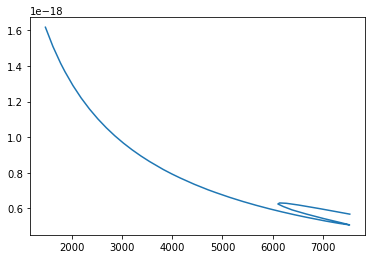

In [12]:
plt.plot(temp_arr, alphaHII_arr)

### Get values from function for different dark matter models

In [5]:
base = './planck1_20_1024_cold/'
nH_arr, nHII_arr, ne_arr, alphaHII_arr = calc_other_quantities(base)

KeyboardInterrupt: 

### Plot graphs

In [ ]:
plt.plot(z_arr, nH_arr, label='$\\langle n_H \\rangle$')
plt.plot(z_arr, nHII_arr, label='$\\langle n_{HII} \\rangle$')
plt.plot(z_arr, ne_arr, label='$\\langle n_e \\rangle$')
plt.plot(z_arr, alphaHII_arr, label='$\\langle \\alpha_{HII} \\rangle$')
plt.xlabel('Redshift')
plt.ylabel('Number density ($m^{-3}$)')
plt.legend()
plt.savefig("Graphs/{0} Other quantities.jpg".format(datetime.now()), dpi=300)
plt.show()

NameError: name 'plt' is not defined

# Differential equation